In [7]:
%load_ext autoreload
%autoreload 2

In [1]:
from abc import ABC, abstractmethod
import time
from pathlib import Path
import importlib.util
import logging
import time
import signal
import hashlib
from uuid import uuid4
import sys
from typing import Dict, Any
import requests
from PIL import Image

from epdlib import Layout

try:
    from .exceptions import PluginError, ImageError, PluginTimeoutError, FileError, ConfigurationError
except ImportError:
    # support jupyter developement
    from exceptions import PluginError, ImageError, PluginTimeoutError, FileError, ConfigurationError

In [9]:
logger = logging.getLogger(__name__)

In [14]:
class BasePlugin(ABC):
    def __repr__(self):
        return f'Plugin({self.name})'
    
    def __str__(self):
        return str(self.name)    
    
    def __init__(
        self,
        name: str = f'Unset Plugin Name-{uuid4().hex[:5]}',
        uuid: str = None,
        duration: int = 90,
        config: dict = {},
        resolution: tuple =(800, 480),
        screen_mode: str = '1',
        force_onebit: bool = False,
        refresh_interval: int = 30,
        plugin_timeout: int = 30,
        dormant: bool = False,
        cache_expire: int = 2,
        cache_dir: Path = None,
        cache_root: Path = None,
        layout: dict = {},
        *args,
        **kwargs,
        
    ):
        # Create a logger for this class/module
        self.name = name
        self.uuid = uuid or 'self_set-' + str(uuid4())[:8]
        logger.debug("BasePlugin instance created.")
        logger.debug(f"Name: {self.name}, uuid: {self.uuid}")
        # self.update_function = self.default_update_function
        self.disabled = False
        self.consecutive_failures = 0
        self.state = "idle"
        
        self.duration = duration
        self.refresh_interval = refresh_interval
        self.plugin_timeout = plugin_timeout
        self.dormant = dormant
        self.last_updated = 0
        self.active = False
        self.resolution = resolution
        self.screen_mode = screen_mode
        self.force_onebit = force_onebit
        self.image = None
        self.config = config
        self.data = {}
        self.agent_string = "PaperPi"
        self.layout = layout

        # Cache directory (initialize before cache session)
        self.cache_root = cache_root
        self.cache_dir = cache_dir  

        # Cache expiration (handled after session initialization)
        self.cache_expire = cache_expire  

        self.high_priority = False
        # # load the update_function
        # if self.plugin_path:
        #     self.load_update_function()


    @abstractmethod
    def update_data(self, **kwargs) -> Dict[str, Any]:
        """
        Subclasses must implement. Should return:
            {'success': bool, 'data': dict, 'high_priority': bool}
        """
        raise NotImplementedError


    # @property
    # def update_function(self):
    #     '''update function provided by the plugin module
        
    #     The update_function is called by the update method to provide status and data for 
    #     the Plugin.
        
    #     Args:
    #         function(function): function that accepts self, *args, **kwargs
            
    #     Returns:
    #         tuple of is_updated(bool), data(dict), priority(int)'''
    #     return self._update_function

    # @update_function.setter
    # def update_function(self, function):
    #     if not function:
    #         raise TypeError('Must be of type function')
    #     else:
    #         self._update_function = function.__get__(self)

    # def default_update_function(self, *args, **kwargs) -> dict:
        # """
        # Default no-op update function for plugins that don't implement their own.
        # Returns a success=False indicating no update was performed.
        # """
        # logger.warning(f"{self.name} - Running default update_function. No update provided.")
        # return {'data': {}, 'success': False}
    

    def update(self, *args, force=False, **kwargs) -> bool:
        """
        Perform an update with timeout logic to prevent blocking.

        Args:
            force (bool): Force update regardless of refresh interval.
            *args, **kwargs: Additional arguments for the update_function.

        Returns:
            bool: True if update succeeded, False if failed or timed out.

        Raises:
            PluginTimeoutError: Raised if the plugin exceeds the timeout period.
        """
        # Skip update if not ready and force is False
        if not force and not self.ready_for_update:
            logger.info(f"{self.name} - Skipping update. Need to wait {self.time_to_refresh:.2f} seconds.")
            return True
    
        logger.info(f"{self.name} - Running update (force={force})...")
        signal.signal(signal.SIGALRM, self.timeout_handler)
        signal.alarm(self.plugin_timeout)  # e.g., 30s default timeout

        try:
            result = self.update_data(*args, **kwargs)
            
            data = result.get('data', {})
            update_success = bool(update_data.get('success', False))
            high_priority = bool(update_data.get('high_priority', False))

            if update_success:
                self.last_updated = time.monotonic()
                logger.info(f"{self.name} - Update successful.")


                self.data = result
                self.epd_layout.update_contents(data)
                
                # Generate or update the final image
                self.image = self.epd_layout.concat()

                self.high_priority = high_priority
                logger.info(f"{self.name} - Image updated via layout.concat().")
                return True
            else:
                logger.warning(f"{self.name} - Update failed. No data returned.")
                return False

        except PluginTimeoutError as e:
            logger.error(f"{self.name} - Plugin hung and timed out: {e}")
            return False

        except Exception as e:
            logger.error(f"{self.name} - Exception during update: {e}")
            return False

        finally:
            signal.alarm(0)  # Disable the alarm
            
    def download_image(self, url: str) -> Path:
        """
        Download and cache an image from the provided URL.

        Args:
            url (str): URL of the image to download.

        Returns:
            Path: Path to the downloaded or cached image.

        Raises:
            FileError: If the image cannot be saved to disk.
            PluginError: If the download fails or the response is invalid.
        """
        try:
            # Create cache file path based on URL and plugin name
            cache_path = self.cache_dir / f"{self.name}_{Path(url).name}"
            expiration_seconds = self.cache_expire * 86400  # Cache expiration in seconds

            # Check if the cached file exists and is still valid
            if cache_path.is_file():
                file_age = time.time() - cache_path.stat().st_mtime
                if file_age < expiration_seconds:
                    logger.info(f"{self.name} - Loading image from cache: {cache_path}")
                    return cache_path  # Return path directly if valid

                logger.info(f"{self.name} - Cached image expired. Re-downloading...")

            # Download the image if not cached or expired
            logger.info(f"{self.name} - Downloading image from {url}")
            response = requests.get(url, headers={"User-Agent": self.agent_string}, stream=True)
            response.raise_for_status()

            # Save the image directly to the cache path
            try:
                with open(cache_path, 'wb') as f:
                    for chunk in response.iter_content(1024):
                        f.write(chunk)
                
                logger.info(f"{self.name} - Image saved at {cache_path}")
                return cache_path

            except IOError as e:
                logger.error(f"{self.name} - Failed to save image to {cache_path}: {e}")
                raise FileError("Failed to save image to disk.", plugin_name=self.name)

        except requests.exceptions.RequestException as e:
            logger.error(f"{self.name} - Failed to download image: {e}")
            raise PluginError(f"Failed to download image from {url}.", plugin_name=self.name)
            
    def reset_priority(self):
        self.high_priority = False
    
    @property
    def dormant(self) -> bool:
        """
        Property to indicate if this is a normally dormant plugin
        
        Returns:
            bool
        """
        return self._dormant

    @dormant.setter
    def dormant(self, value):
        """
        Set the dormant and high_priority values
        """
        if not isinstance(value, bool):
            raise ValueError('Must be of type bool')
        self._dormant = value
        self.high_priority = False

    @property
    def high_priority(self) -> bool:
        return self._high_priority

    @high_priority.setter
    def high_priority(self, value):
        if not isinstance(value, bool):
            raise ValueError('Must be of type bool')
        self._high_priority = value
    
    @property
    def image_hash(self) -> str:
        """
        Provide a hash based on image 
        
        Provides easy comparision if the image has been updated and needs to be refreshed
        
        Returns:
            str: Hex digest of image hash
        """

        if not self.image:
            return ""
        image_bytes = self.image.tobytes()
        return hashlib.md5(image_bytes).hexdigest()
            
    @property
    def resolution(self) -> tuple:
        """
        Property to show the set resolution for the attached screen
        
        Returns:
            tuple: (Width x Height)
        """
        return self._resolution

    @resolution.setter
    def resolution(self, value):
        if not isinstance(value, (tuple, list)):
            raise TypeError(f'Resolution must be a tuple or list')
        if len(value) != 2:
            raise ValueError(f'Resolution must have length == 2')
        if not all(isinstance(v, int) for v in value):
            raise ValueError('Resolution values must be type int')
        for i in value:
            if i <=0:
                raise ValueError('Resolution values must be > 0')

        self._resolution = value

    @property 
    def force_onebit(self) -> bool:
        return self._force_onebit

    @force_onebit.setter
    def force_onebit(self, value):
        if not isinstance(value, bool):
            raise TypeError('Must be type bool')
        self._force_onebit = value

    @property
    def screen_mode(self) -> str:
        return self._screen_mode

    @screen_mode.setter
    def screen_mode(self, value):
        valid_modes = ('L',    # Gray scale
                       '1',    # one bit
                       'RGB'   # RGB Color
                      )
        
        if not isinstance(value, str):
            raise TypeError('Must be type str')
        if value.upper() not in valid_modes:
            raise ValueError(f'Valid modes: {valid_modes}')
        self._screen_mode = value
    
    
    @property
    def ready_for_update(self) -> bool:
        """
        Property to check if the plugin is ready for an update based on refresh interval.

        Returns:
            bool: True if the refresh interval has elapsed since the last update.
        """
        elapsed_time = time.monotonic() - self.last_updated
        return elapsed_time >= self.refresh_interval

    @property
    def time_to_refresh(self) -> float:
        """
        Property displaying time remaining until update is possible.
        
        Returns:
            float: Time remaining until the next update (in seconds). 
                   Returns 0 if the plugin is ready for refresh.
        """
        elapsed_time = time.monotonic() - self.last_updated
        remaining_time = self.refresh_interval - elapsed_time
        # remaining_time = elapsed_time - self.refresh_interval
        return max(remaining_time, 0)  # Return 0 if already ready
    
    @property
    def cache_expire(self):
        return self._cache_expire

    @cache_expire.setter
    def cache_expire(self, value):
        if not isinstance(value, (int, float)):
            raise TypeError(f"Invalid cache_expire value: '{value}' must be an integer/float")
        if value <= 0:
            raise ValueError(f"cache_expire must be > 0")
        self._cache_expire = value

        logger.info(f"{self.name} - Cache expiration set to {self.cache_expire} days.")

    @property
    def cache_root(self):
        return self._cache_root

    @cache_root.setter
    def cache_root(self, value):
        if not value:
            value = Path('/tmp/BasePlugin_cache/')
            
        if not isinstance(value, (Path, str)):
            raise TypeError(f"Invalid cache_root value: '{value}' must be a string or Path.")
        self._cache_root = Path(value)
        self._cache_root.mkdir(parents=True, exist_ok=True)
        
    @property
    def cache_dir(self):
        return self._cache_dir

    @cache_dir.setter
    def cache_dir(self, value):
        if not value:
            value = self.cache_root / self.name
        if not isinstance(value, (Path, str)):
            raise TypeError(f"Invalid cache_dir value: '{value}' must be a string or Path.")
        logger.info(f"{self.name} - Using cache directory: {value}")
        self._cache_dir = self.cache_root / value
        self._cache_dir.mkdir(parents=True, exist_ok=True)

    @property
    def layout(self):
        return self._layout

    @layout.setter
    def layout(self, layout):
        if not isinstance(layout, dict):
            raise TypeError('Must be type dict')
        # convert layout blocks to RGB when possible
        for block, values in layout.items():
            if values.get('rgb_support', False) and self.screen_mode == 'RGB' and not self.force_onebit:
                logging.info(f'Converting {block} to RGB')
                values['mode'] = 'RGB'

        self._layout = layout

        # reset the layout object when the layout is updated.
        self.epd_layout = Layout(
            resolution=self.resolution,
            layout=self._layout,
            force_onebit=self.force_onebit,
            mode=self.screen_mode
        )

    def clear_cache(self, all_files: bool = False):
        """
        Clear the cache by removing expired or all files.

        Args:
            all_files (bool): If True, delete all files in the cache directory.
                              If False, delete only expired files.
        """
        now = time.time()
        expiration_seconds = self.cache_expire * 86400

        logging.debug(f"Removing cached files from {self.cache_dir} older than {self.cache_expire} days")

        for file in self.cache_dir.glob(f"{self.name}_*"):
            try:
                # Remove all files or only expired ones
                if all_files or (now - file.stat().st_mtime > expiration_seconds):
                    logger.info(f"{self.name} - Removing cached file: {file}")
                    file.unlink()
            except Exception as e:
                logger.error(f"{self.name} - Failed to remove cache file {file}: {e}")
                raise FileError(f"Failed to delete {file}.", plugin_name=self.name)

    def timeout_handler(self, signum, frame):
        """Raise a timeout error when the plugin update hangs."""
        raise PluginTimeoutError("Plugin update timed out.", plugin_name=self.name)

    def mark_failure(self, reason: str = "None Provided") -> None:
        """
        Increment failure counter; PluginManager decides when to disable using this information
        """
        self.consecutive_failures += 1
        logger.warning(f'{self.name} - failure #{self.consecutive_failures} with reason: {reason}')

    def mark_success(self) -> None:
        """
        Clear consecutive failure counter after a good update
        """
        if self.consecutive_failures:
            logger.info(f'{self.name} - resetting consecutive_failure count {self.consecutive_failures} -> 0')
            self.consecutive_failures = 0

    def setup(self) -> None:
        """Optional hook for plugin-specific initialization."""
        logger.debug("%s - setup()", self.name)
    
    def teardown(self) -> None:
        """Optional hook for plugin-specific cleanup."""
        logger.debug("%s - teardown()", self.name)

In [6]:
# import random
# import time
# from datetime import datetime
# from IPython.display import display

# # class ClockPlugin(BasePlugin):
# def update_function(self, *args, **kwargs):
#     """
#     Provides system time string in the format HH:MM.

#     Returns:
#         dict: Contains update success, data, and priority.
#     """

#     rand_hang = kwargs.get('rand_hang', 0.2)
#     # # Simulate random failure (20% chance)
#     # if random.random() < 0.2:  # 20% failure rate
#     #     logger.warning(f"{self.name} - Simulated update failure.")
#     #     return {'data': {}, 'success': False}

#     # Simulate random hang (20% chance, 5 to 20 seconds delay)

#     if random.random() < rand_hang:
#         delay = random.randint(5, 20)
#         logger.warning(f"{self.name} - Simulated hang for {delay} seconds.")
#         time.sleep(delay)

#     if random.random() > 0.5:
#         high_priority = True
#     else:
#         high_priority = False
#     logger.info(f'High priority: {high_priority}')
    
#     # Normal update logic
#     current_time = datetime.now().strftime("%H:%M")
#     image = self.download_image(
#         'https://upload.wikimedia.org/wikipedia/commons/d/da/Amphipoea_oculea_-_Keila.jpg'
#     )
#     data = {'digit_time': current_time, 'image': image}
#     logger.info(f"{self.name} - Time updated: {current_time}")
    
#     return {'data': data, 'success': True, 'high_priority': high_priority}

# dir_path = Path().resolve()
# layout = {
#     'digit_time': {
#         'type': 'TextBlock',
#         'image': None,
#         'max_lines': 2,
#         'width': 1,
#         'height': .5,
#         'abs_coordinates': (0, 0),
#         'rand': True,
#         # 'font': dir_path/'/../../fonts/Kanit/Kanit-Medium.ttf',
#         'font': dir_path / '../fonts/Kanit/Kanit-Medium.ttf',
#         'mode': 'L',
#         'fill': 'BLACK',
#         'bkground': 'WHITE'
#     },
#     'image': {
#         'type': 'ImageBlock',
#         'image': True,
#         'width': 1,
#         'height': 0.5,
#         'abs_coordinates': (0, None),
#         'relative': ['image', 'digit_time'],
#         'mode': 'RGB'
#     }
# }

# # Instantiate the ClockPlugin
# p = BasePlugin(
#     name="Clock",
#     duration=10,
#     config={},
#     plugin_timeout = 5,
#     screen_mode = 'RGB',
#     layout = layout,
#     dormant=True
# )

# p.update_function = update_function

High priority plugin breaks thru!


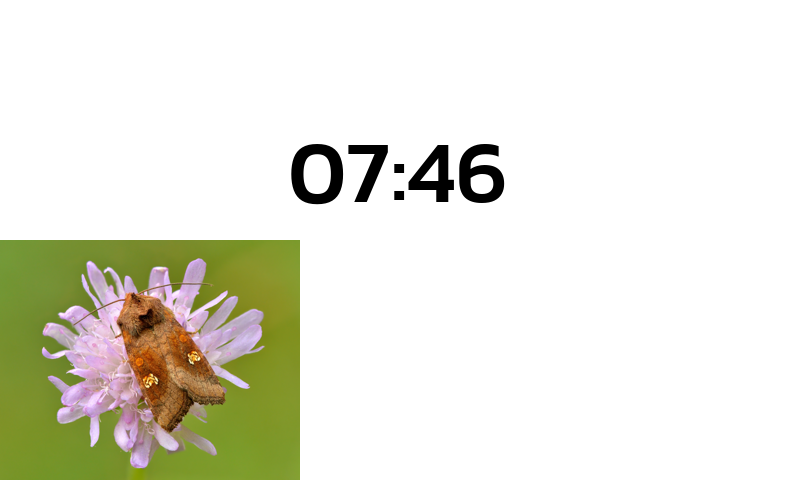

In [10]:
# p.update(rand_hang=0, force=True)
# if p.high_priority:
#     print('High priority plugin breaks thru!')
#     display(p.image)
# else:
#     print('low priority - no image')